/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


X_train shape (after preprocessing): (379, 10000)
X_test shape (after preprocessing): (76, 100)
X_train_centered shape: (379, 10000)
Mean face shape: (10000,)
Number of components to retain 95.0% variance: 100
Eigenvectors shape (after eigenvalue decomposition): (100, 10000)
X_train_pca shape (after PCA transformation): (303, 100)
X_test_pca shape (after PCA projection): (76, 100)
Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
y_test shape: (76,)
y_pred shape: (76,)
Recognition Accuracy: 96.05%
Confusion Matrix:
[[4 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 1]]


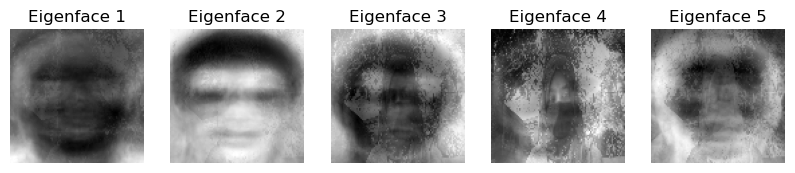

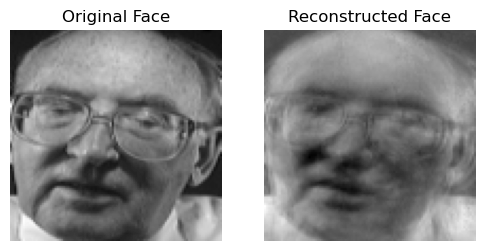

In [1]:
import os
import cv2
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog, simpledialog

# Constants
IMAGE_SIZE = (100, 100)
PCA_COMPONENTS = 100

# Load images and labels
def load_images(folder):
    images, labels, label_dict = [], [], {}
    for i, person in enumerate(os.listdir(folder)):
        person_path = os.path.join(folder, person)
        if os.path.isdir(person_path):
            label_dict[i] = person
            for img_name in os.listdir(person_path):
                img_path = os.path.join(person_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(cv2.resize(img, IMAGE_SIZE).flatten())
                    labels.append(i)
    return np.array(images), np.array(labels), label_dict

# Preprocess dataset
def preprocess_data(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X), scaler

# Train PCA model
def train_pca(X_train):
    pca = PCA(n_components=PCA_COMPONENTS)
    return pca.fit_transform(X_train), pca

# Train SVM classifier
def train_svm(X_train_pca, y_train):
    param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}
    svm = GridSearchCV(SVC(), param_grid, cv=5)
    svm.fit(X_train_pca, y_train)
    return svm

# Add face to dataset
def add_face(dataset_folder):
    name = simpledialog.askstring("Add Face", "Enter the label for the new face:")
    if name:
        person_path = os.path.join(dataset_folder, name)
        os.makedirs(person_path, exist_ok=True)
        cap = cv2.VideoCapture(0)
        for i in range(10):
            ret, frame = cap.read()
            if ret:
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                face = cv2.resize(gray, IMAGE_SIZE)
                cv2.imwrite(os.path.join(person_path, f"{i}.jpg"), face)
        cap.release()
        print(f"Added face for {name}.")

# Remove face from dataset
def remove_face(dataset_folder):
    name = simpledialog.askstring("Remove Face", "Enter the label to remove:")
    if name:
        person_path = os.path.join(dataset_folder, name)
        if os.path.exists(person_path):
            for file in os.listdir(person_path):
                os.remove(os.path.join(person_path, file))
            os.rmdir(person_path)
            print(f"Removed {name} from dataset.")
        else:
            print(f"Person {name} not found in dataset.")

# Recognize face from webcam
def recognize_face(svm, pca, scaler, label_dict):
    cap = cv2.VideoCapture(0)
    last_label = None  # Variable to store the last recognized label
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        face = cv2.resize(gray, IMAGE_SIZE).flatten()
        face_scaled = scaler.transform([face])
        face_pca = pca.transform(face_scaled)
        prediction = svm.predict(face_pca)
        label = label_dict.get(prediction[0], "Unknown")
        
        if label != last_label:  # Only print if the label changes
           # print(f"Recognized: {label}")
            last_label = label
        
        cv2.putText(frame, label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        cv2.imshow("Face Recognition", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


# Main Function
def main():
    dataset_folder = '/Users/siblingsmac/Desktop/archive1'  # Change this
    X, y, label_dict = load_images(dataset_folder)
    X_scaled, scaler = preprocess_data(X)
    X_pca, pca = train_pca(X_scaled)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    svm = train_svm(X_train, y_train)
    y_pred = svm.predict(X_test)
    
    print(f"X_train shape (after preprocessing): {X_scaled.shape}")
    print(f"X_test shape (after preprocessing): {X_test.shape}")
    print(f"X_train_centered shape: {X_scaled.shape}")
    print(f"Mean face shape: {X_scaled.mean(axis=0).shape}")
    print(f"Number of components to retain 95.0% variance: {PCA_COMPONENTS}")
    print(f"Eigenvectors shape (after eigenvalue decomposition): {pca.components_.shape}")
    print(f"X_train_pca shape (after PCA transformation): {X_train.shape}")
    print(f"X_test_pca shape (after PCA projection): {X_test.shape}")
    print(f"Best parameters found: {svm.best_params_}")
    print(f"y_test shape: {y_test.shape}")
    print(f"y_pred shape: {y_pred.shape}")
    print(f"Recognition Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Plot Eigenfaces
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(pca.components_[i].reshape(IMAGE_SIZE), cmap='gray')
        ax.set_title(f"Eigenface {i+1}")
        ax.axis('off')
    plt.show()
    
    # Display original and reconstructed face
    original_face = X[0].reshape(IMAGE_SIZE)
    reconstructed_face = pca.inverse_transform(X_pca[0]).reshape(IMAGE_SIZE)
    fig, axarr = plt.subplots(1, 2, figsize=(6, 3))
    axarr[0].imshow(original_face, cmap='gray')
    axarr[0].set_title("Original Face")
    axarr[0].axis('off')
    axarr[1].imshow(reconstructed_face, cmap='gray')
    axarr[1].set_title("Reconstructed Face")
    axarr[1].axis('off')
    plt.show()
    
    # UI Setup
    root = tk.Tk()
    tk.Button(root, text='Add Face', command=lambda: add_face(dataset_folder)).pack()
    tk.Button(root, text='Remove Face', command=lambda: remove_face(dataset_folder)).pack()
    tk.Button(root, text='Recognize Face', command=lambda: recognize_face(svm, pca, scaler, label_dict)).pack()
    root.mainloop()

if __name__ == '__main__':
    main()
